In [1]:
from jax.config import config
config.update("jax_enable_x64", True)
import multiprocess as mp
mp.set_start_method('spawn') # JAX doesn't allow fork
import os, os.path
import numpy
from galpy.potential import NFWPotential
from galpy.df import eddingtondf, osipkovmerrittdf, isotropicNFWdf, osipkovmerrittNFWdf, constantbetadf
from galpy.df import jeans
from galpy.util import plot as galpy_plot
galpy_plot.start_print(axes_labelsize=17.,text_fontsize=12.,
                       xtick_labelsize=15.,ytick_labelsize=15.)
_SAVE_FIGURES= True
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Approximate analytical DFs for the NFW profile

We consider the standard NFW profile

\begin{equation}\label{eq-twopower-dens}
    \rho(r) = \frac{\rho_0}{r/a\,(1+r/a)^2}\,,
\end{equation}

with potential

\begin{equation}
    \Phi(r) = -4\pi\,G\,\rho_0\,a^2\,\ln(1+r/a)/(r/a)\,.
\end{equation}


## Isotropic (ergodic) DF

We can compute the isotropic DF for the NFW profile using the Eddington inversion

\begin{equation}
    f(\mathcal{E}) = \frac{1}{\sqrt{8}\,\pi^2}\,\left[\int_0^\mathcal{E}\mathrm{d}\Psi\,\frac{1}{\sqrt{\mathcal{E}-\Psi}}\,\frac{\mathrm{d}^2\rho}{\mathrm{d}\Psi^2} +\frac{1}{\sqrt{\mathcal{E}}}\,\frac{\mathrm{d}\rho}{\mathrm{d}\Psi}\Bigg|_{\Psi=0}\right]\,,
\end{equation}

where quantities are defined in the *usual way*. We will work in the following units: radii are expressed as fractions of the scale radius $a$, binding energies $\mathcal{E}$ in units of the maximum binding energy $\Psi_0 = 4\pi\,G\,\rho_0\,a^2$, and the DF in units of inverse $(4\pi G)^{3/2}\,a^3\,\rho_0^{1/2}$. To setup this scaled NFW profile in ``galpy``, we set `a=1` and `amp=1` ($4\pi\rho_0=1$ for $G=1$ units); the DF units are then $1/(4\pi)$.

In [3]:
np= NFWPotential(amp=1.,a=1.)

Next, we set up the `eddingtondf` for this NFW profile

In [4]:
edf= eddingtondf(np)

and we compute $f(\mathcal{E})$ (multiplying the raw output by $4\pi$ to get the DF in the scaled units)

In [5]:
mEs= numpy.linspace(-np(0,0)*0.995,0,201)
fmE= 4.*numpy.pi*edf.fE(-mEs)

and we can plot it

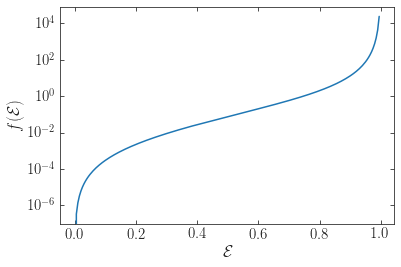

In [6]:
semilogy(mEs,fmE)
xlabel(r'$\mathcal{E}$')
ylabel(r'$f(\mathcal{E})$');

According to [Widrow (2000)](https://ui.adsabs.harvard.edu/abs/2000ApJS..131...39W/abstract), this is well represented by a form similar to

\begin{equation}
    f(\mathcal{E}) \propto \mathcal{E}^{3/2}\,(1-\mathcal{E})^{-5/2}\,\left({-\ln \mathcal{E} \over 1-\mathcal{E}}\right)^{-2.75}\,.
\end{equation}

so let's divide out this form

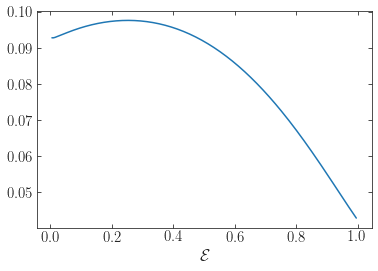

In [7]:
def fE_widrowapprox(mE):
    return mE**1.5*(1.-mE)**-2.5*(-numpy.log(mE)/(1-mE))**-2.75
plot(mEs[:-1],fmE[:-1]/fE_widrowapprox(mEs[:-1]))
xlabel(r'$\mathcal{E}$');

This looks like a pretty simple relation! We can fit it with a polynomial

In [8]:
coeff= numpy.polyfit(mEs[:-1],fmE[:-1]/fE_widrowapprox(mEs[:-1]),deg=10)

In [9]:
numpy.set_printoptions(formatter={'float': lambda x: "{0:0.16f}".format(x)})
coeff

array([7.8480631889123114, -41.0268009529575863, 92.5144063082258157,
       -117.6477872907975382, 92.6397009471828170, -46.6587221550257851,
       14.9776586391246376, -2.9784827749197880, 0.2583468299241013,
       0.0232272797489981, 0.0926081086527954])

which works pretty well:

/Users/bovy/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  

/Users/bovy/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  



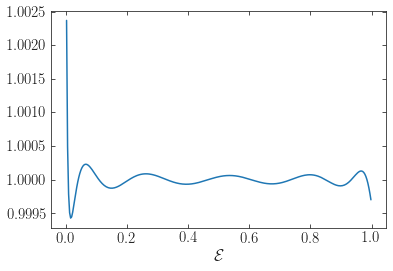

In [10]:
newmEs= numpy.linspace(-np(0,0)*0.9975,0,301)
plot(newmEs,4.*numpy.pi*edf.fE(-newmEs)/fE_widrowapprox(newmEs)/numpy.polyval(coeff,newmEs))
xlabel(r'$\mathcal{E}$');

Let's print the resulting polynomial:

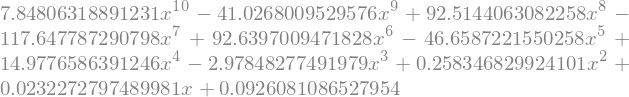

In [11]:
import sympy as sp
from sympy.abc import x
sp.init_printing()
sp.Poly(coeff,x).as_expr()

In [12]:
sp.latex(sp.Poly(coeff,x).as_expr())

'7.84806318891231 x^{10} - 41.0268009529576 x^{9} + 92.5144063082258 x^{8} - 117.647787290798 x^{7} + 92.6397009471828 x^{6} - 46.6587221550258 x^{5} + 14.9776586391246 x^{4} - 2.97848277491979 x^{3} + 0.258346829924101 x^{2} + 0.0232272797489981 x + 0.0926081086527954'

Thus, we use 

\begin{equation}
\begin{split}
    f(\mathcal{E}) = \mathcal{E}^{3/2}& \,(1-\mathcal{E})^{-5/2}\,\left({-\ln \mathcal{E} \over 1-\mathcal{E}}\right)^{-2.75}\,\\
    & \times \left(7.84806318891231 \mathcal{E}^{10} - 41.0268009529576 \mathcal{E}^{9} + 92.5144063082258 \mathcal{E}^{8} - 117.647787290798 \mathcal{E}^{7} + 92.6397009471828 \mathcal{E}^{6} - 46.6587221550258 \mathcal{E}^{5} + 14.9776586391246 \mathcal{E}^{4} - 2.97848277491979 \mathcal{E}^{3} + 0.258346829924101 \mathcal{E}^{2} + 0.0232272797489981 \mathcal{E} + 0.0926081086527954\right).
\end{split}
\end{equation}

This is implemented in `isotropicNFWdf` and we can initialize this DF to compare its density to that of the target NFW profile. We also compare to how the approximate DF from Widrow (2000) does:

In [13]:
ndf= isotropicNFWdf(np,rmax=numpy.inf) # rmax=inf to avoid sampling cut-off
nwdf= isotropicNFWdf(np,widrow=True)

Let's compare the densities:

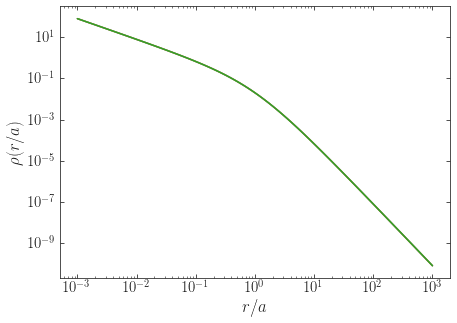

In [46]:
rs= numpy.geomspace(1e-3,1e3,101)
loglog(rs,np.dens(rs,0))
loglog(rs,[ndf.vmomentdensity(r,0,0) for r in rs])
loglog(rs,[nwdf.vmomentdensity(r,0,0) for r in rs])
xlabel(r'$r/a$')
ylabel(r'$\rho(r/a)$');

All three agree well! But let's look more carefully at the relative density

In [47]:
figsize(7,5)
rs= numpy.geomspace(1e-3,1e3,101)
semilogx(rs,[ndf.vmomentdensity(r,0,0)/np.dens(r,0)-1 for r in rs],
        label=r'$\mathrm{Lane,\ Bovy,\ \&\ Mackereth\ (2021)}$')
semilogx(rs,[nwdf.vmomentdensity(r,0,0)/np.dens(r,0)-1 for r in rs],
         label=r'$\mathrm{Widrow\ (2000)}$')
xlabel(r'$r/a$')
ylabel(r'$\rho(r/a)/\rho^{\mathrm{true}}(r/a)-1$')
ylim(-0.0065,0.0065)
legend(fontsize=17.,frameon=False);
if _SAVE_FIGURES:
    galpy_plot.end_print('../plots/ergodic_nfw_denscomp.pdf',bbox_inches='tight')

Thus, the new form agrees much better with the target density than that of Widrow (2000) (but both are quite good!). We can also look at the radial velocity dispersion and compare it to the expected trend from solving the Jeans equation:

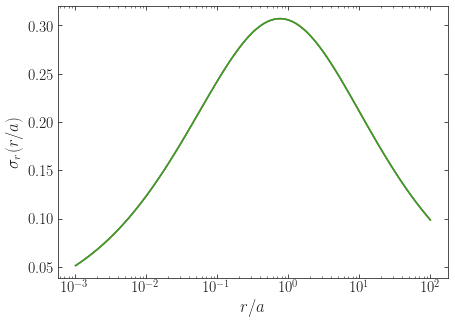

In [48]:
rs= numpy.geomspace(1e-3,1e2,101)
semilogx(rs,numpy.array([jeans.sigmar(np,r,beta=0.) for r in rs]))
semilogx(rs,[ndf.sigmar(r) for r in rs])
semilogx(rs,[nwdf.sigmar(r) for r in rs])
xlabel(r'$r/a$')
ylabel(r'$\sigma_r(r/a)$');

Let's again also look at the relative performance:

In [49]:
semilogx(rs,[ndf.sigmar(r)/jeans.sigmar(np,r,beta=0.)-1. for r in rs],
         label=r'$\mathrm{Lane,\ Bovy,\ \&\ Mackereth\ (2021)}$')
semilogx(rs,[nwdf.sigmar(r)/jeans.sigmar(np,r,beta=0.)-1. for r in rs],
         label=r'$\mathrm{Widrow\ (2000)}$')         
xlabel(r'$r/a$')
ylabel(r'$\sigma_r(r/a)/\sigma^{\mathrm{true}}_r(r/a)-1$')
ylim(-0.0012,0.0012)
legend(fontsize=17.,frameon=False);
if _SAVE_FIGURES:
    galpy_plot.end_print('../plots/ergodic_nfw_sigmacomp.pdf',bbox_inches='tight')

## Osipkov-Merritt DF

The Osipkov-Merritt DF is that with increasing anisotropy $\beta(r) = 1/(1+r_a^2/r^2)$, which is obtained from the DF

\begin{equation}
    f(\mathcal{E},L) = f(Q) = f(\mathcal{E}-{L^2 \over 2r_a^2})\,.
\end{equation}

This DF can be computed for a given (potential,density) pair using

\begin{equation}
    f(Q) = f^{\beta=0}(Q)+\frac{1}{\sqrt{8}\,\pi^2\,r_a^2}\,\left[\int_0^Q\mathrm{d}\Psi\,\frac{1}{\sqrt{Q-\Psi}}\,\frac{\mathrm{d}^2}{\mathrm{d}\Psi^2}\Big[\rho(\Psi)\,r^2(\Psi)\Big]+\frac{1}{\sqrt{Q}}\,\frac{\mathrm{d}}{\mathrm{d}\Psi}\Big[\rho(\Psi)\,r^2(\Psi)\Big]\Big|_{\Psi=0}\right]\,,
\end{equation}

where $f^{\beta=0}(Q)$ is the isotropic DF evaluated at $Q$. The second term on the right-hand side is zero and, thus, to get the Osipkov-Merritt DF, we can combine the ergodic DF from above with

\begin{equation}
    \Delta f(Q) = \frac{a^2}{\sqrt{8}\,\pi^2\,r_a^2}\,\int_0^Q\mathrm{d}\Psi\,\frac{1}{\sqrt{Q-\Psi}}\,\frac{\mathrm{d}^2}{\mathrm{d}\Psi^2}\Big[\rho(\Psi)\,r^2(\Psi)\Big]\,,
\end{equation}

where we have brought $a^2$ out of the integral such that $r$ is the scaled radius now.

To compute this integral, we can make use of the `osipkovmerrittdf` class in `galpy`, but we have to hack it to just compute this integral rather than the entire Osipkov-Merritt DF (we implement the hack in full generality ...):

In [50]:
from galpy.potential import evaluateDensities
odf= osipkovmerrittdf(pot=np,ra=1.)
odf._edf._dnudr= \
           (lambda r: odf._denspot._ddensdr(r)*r**2./odf._ra2 \
                   +2.*odf._denspot.dens(r,0,use_physical=False)*r/odf._ra2)\
           if not isinstance(odf._denspot,list) \
           else (lambda r: numpy.sum([p._ddensdr(r) for p in odf._denspot])\
                *(r**2./odf._ra2)\
                +2.*evaluateDensities(odf._denspot,r,0,use_physical=False)\
                *r/odf._ra2)
odf._edf._d2nudr2= \
           (lambda r: odf._denspot._d2densdr2(r)*r**2./odf._ra2 \
                    +4.*odf._denspot._ddensdr(r)*r/odf._ra2 \
                    +2.*odf._denspot.dens(r,0,use_physical=False)/odf._ra2)\
           if not isinstance(odf._denspot,list) \
           else (lambda r: numpy.sum([p._d2densdr2(r) for p in odf._denspot])\
                *(r**2./odf._ra2)\
                +4.*numpy.sum([p._ddensdr(r) for p in odf._denspot])\
                    *r/odf._ra2 \
                +2.*evaluateDensities(odf._denspot,r,0,use_physical=False)\
                /odf._ra2)

Then we compute the integral:

In [51]:
# we can re-use mEs from above as Qs!
Qs= mEs
dfQ= 4.*numpy.pi*odf.fQ(Qs)

/Users/bovy/tmp/galpy-spheredf/galpy/df/eddingtondf.py:120: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  0.,0.5/self._rphi(tE))[0] for tE in Eint[indx]])

/Users/bovy/tmp/galpy-spheredf/galpy/df/eddingtondf.py:120: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  0.,0.5/self._rphi(tE))[0] for tE in Eint[indx]])



We find that $\Delta f(Q) \propto {1 \over Q^{2/3}}\,\left({1-Q \over \ln Q}\right)^2$, so we plot $\Delta f(Q)\,Q^{2/3}\,\left({\ln Q \over 1-Q}\right)^2$:

/Users/bovy/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  

/Users/bovy/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  



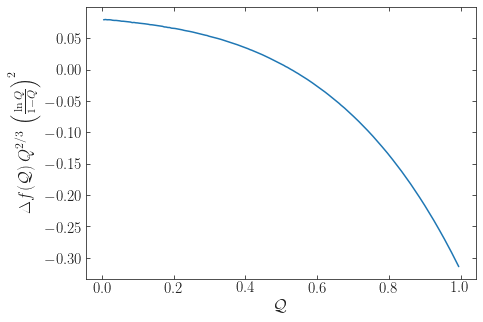

In [52]:
qpow= 2./3.
plot(Qs,dfQ*Qs**qpow*(numpy.log(Qs)/(1-Qs))**2.)
xlabel(r'$\mathcal{Q}$')
ylabel(r'$\Delta f(\mathcal{Q})\,Q^{2/3}\,\left({\ln Q \over 1-Q}\right)^2$');

We're left with a pretty simple looking function that we can try to fit with a polynomial again:

In [53]:
coeff= numpy.polyfit(Qs[:-1],dfQ[:-1]*Qs[:-1]**qpow*(numpy.log(Qs[:-1])/(1-Qs[:-1]))**2.,deg=8)

In [54]:
numpy.set_printoptions(formatter={'float': lambda x: "{0:0.16f}".format(x)})
coeff

array([-0.9958957901383353, 4.2905266124525259, -7.6069046709185919,
       7.0313234865878806, -3.6920719890718035, 0.8313023634615980,
       -0.2179687331774083, -0.0408426627412238, 0.0802975743915827])

which works pretty well:

/Users/bovy/tmp/galpy-spheredf/galpy/df/eddingtondf.py:120: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  0.,0.5/self._rphi(tE))[0] for tE in Eint[indx]])

/Users/bovy/tmp/galpy-spheredf/galpy/df/eddingtondf.py:120: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  0.,0.5/self._rphi(tE))[0] for tE in Eint[indx]])

/Users/bovy/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  

/Users/bovy/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

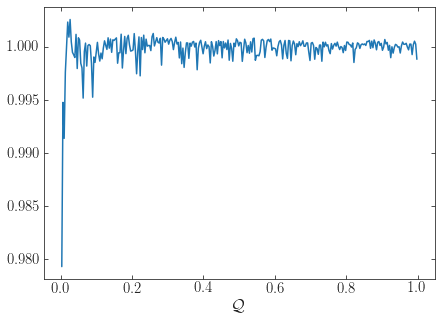

In [55]:
newQs= numpy.linspace(-np(0,0)*0.9975,0,301)
approx_diff= (4.*numpy.pi*odf.fQ(newQs)-numpy.polyval(coeff,newQs)/(newQs**qpow*(numpy.log(newQs)/(1-newQs))**2.))
plot(newQs,1.+approx_diff/0.1)
xlabel(r'$\mathcal{Q}$');

Let's print the resulting polynomial:

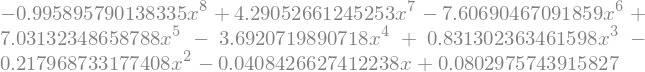

In [56]:
sp.Poly(coeff,x).as_expr()

In [57]:
sp.latex(sp.Poly(coeff,x).as_expr())

'- 0.995895790138335 x^{8} + 4.29052661245253 x^{7} - 7.60690467091859 x^{6} + 7.03132348658788 x^{5} - 3.6920719890718 x^{4} + 0.831302363461598 x^{3} - 0.217968733177408 x^{2} - 0.0408426627412238 x + 0.0802975743915827'

Thus, we use 

\begin{equation}
\begin{split}
    \Delta f(Q) = & {1 \over Q^{2/3}}\,\left({1-Q \over \ln Q}\right)^2\,\\
    & \times \left(- 0.995895790138335 Q^{8} + 4.29052661245253 Q^{7} - 7.60690467091859 Q^{6} + 7.03132348658788 Q^{5} - 3.6920719890718 Q^{4} + 0.831302363461598 Q^{3} - 0.217968733177408 Q^{2} - 0.0408426627412238 Q + 0.0802975743915827\right).
\end{split}
\end{equation}

This is implemented in `osipkovmerrittNFWdf` and we can initialize this DF to compare its density to that of the target NFW profile. We also compare to the DF directly computed using `osipkovmerrittdf`:

In [58]:
ra= 1.
nodf= osipkovmerrittNFWdf(np,ra=ra,rmax=numpy.inf) # rmax=inf to avoid sampling cut-off
odf= osipkovmerrittdf(pot=np,ra=ra,rmax=numpy.inf) 

Because the necessary $f(Q)$ integral in the straight `osipkovmerrittdf` implementation is calculated numerically each time, we replace the `fQ` function of that object with an interpolated version, which is normally only used for sampling. We can hack this together as follows:

In [59]:
try: odf.sample(n=1)
except ValueError: pass
odf.fQ= lambda x: numpy.exp(odf._logfQ_interp(x))

/Users/bovy/tmp/galpy-spheredf/galpy/df/eddingtondf.py:129: RuntimeWarning: invalid value encountered in sqrt
  /numpy.sqrt(_evaluatePotentials(pot,r,0)-E)

/Users/bovy/tmp/galpy-spheredf/galpy/df/eddingtondf.py:116: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  points=[0.])[0] for tE in Eint[indx]])

/Users/bovy/tmp/galpy-spheredf/galpy/df/eddingtondf.py:116: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  points=[0.])[0] for tE in Eint[indx]])

/Users/bovy/tmp/

Let's then compare the densities:

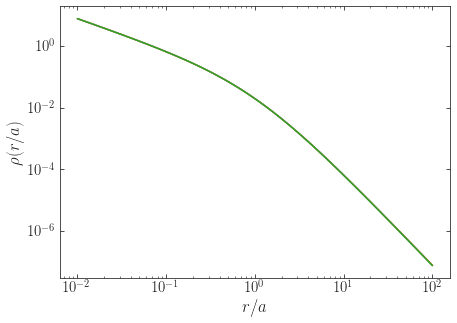

In [60]:
rs= numpy.geomspace(1e-2,1e2,101)
loglog(rs,np.dens(rs,0))
dfdens= [nodf.vmomentdensity(r,0,0) for r in rs]
loglog(rs,dfdens)
odfdens= [odf.vmomentdensity(r,0,0) for r in rs]
loglog(rs,odfdens)
xlabel(r'$r/a$')
ylabel(r'$\rho(r/a)$');

All three agree well! But let's look more carefully at the relative density

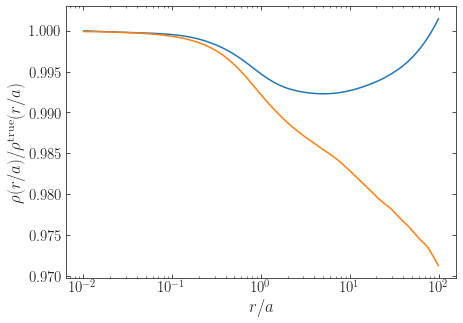

In [61]:
semilogx(rs,numpy.array(dfdens)/np.dens(rs,0))
semilogx(rs,numpy.array(odfdens)/np.dens(rs,0))
xlabel(r'$r/a$')
ylabel(r'$\rho(r/a)/\rho^{\mathrm{true}}(r/a)$');

Thus, the approximate form agrees well with the target density, even a little better than the direct numerical integration of the Osipkov-Merritt DF. Relative density differences are within one percent. We can also look at the radial velocity dispersion and compare it to the expected trend from solving the Jeans equation:

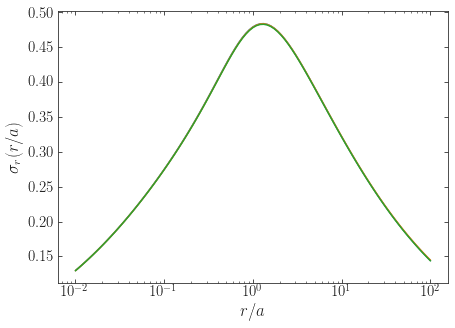

In [62]:
semilogx(rs,numpy.array([jeans.sigmar(np,r,beta=lambda r: 1./(1+ra**2./r**2.)) for r in rs]))
semilogx(rs,[nodf.sigmar(r) for r in rs])
semilogx(rs,[odf.sigmar(r) for r in rs])
xlabel(r'$r/a$')
ylabel(r'$\sigma_r(r/a)$');

Let's again also look at the relative performance:

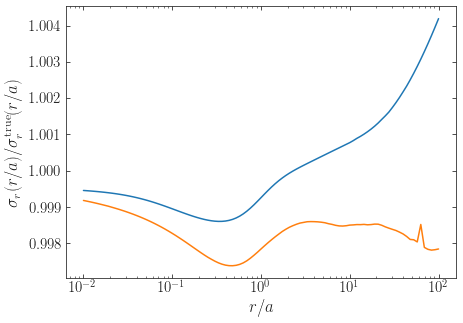

In [63]:
semilogx(rs,[nodf.sigmar(r)/jeans.sigmar(np,r,beta=lambda r: 1./(1+ra**2./r**2.)) for r in rs])
semilogx(rs,[odf.sigmar(r)/jeans.sigmar(np,r,beta=lambda r: 1./(1+ra**2./r**2.)) for r in rs])
xlabel(r'$r/a$')
ylabel(r'$\sigma_r(r/a)/\sigma^{\mathrm{true}}_r(r/a)$');

That again looks quite good! We can also look at $\beta$, but it is important to realize that $\beta$ always has the right form as long as the DF is only a function of $Q$ (that is, even if the density profile is completely wrong!). Thus, the $\beta$ profile is almost exact:

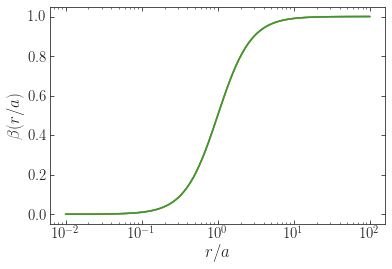

In [31]:
semilogx(rs,1./(1+ra**2./rs**2.))
semilogx(rs,[nodf.beta(r) for r in rs])
semilogx(rs,[odf.beta(r) for r in rs])
xlabel(r'$r/a$')
ylabel(r'$\beta(r/a)$');

as seen especially well in the relative $\beta$:

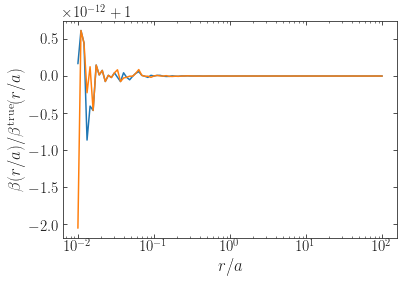

In [32]:
semilogx(rs,[nodf.beta(r)/(1./(1+ra**2./r**2.)) for r in rs])
semilogx(rs,[odf.beta(r)/(1./(1+ra**2./r**2.)) for r in rs])
xlabel(r'$r/a$')
ylabel(r'$\beta(r/a)/\beta^{\mathrm{true}}(r/a)$');

To make sure that our scalings are working as we expect, we can also use a different NFW profile with $a \neq r_a$:

In [33]:
np2= NFWPotential(amp=2.3,a=0.5)

and we then repeat the checks from above, with $r_a = 3 = 6a$:

In [34]:
ra= 3.
nodf= osipkovmerrittNFWdf(np2,ra=ra,rmax=numpy.inf) # rmax=inf to avoid sampling cut-off
odf= osipkovmerrittdf(pot=np2,ra=ra,rmax=numpy.inf) 

Because the necessary $f(Q)$ integral in the straight `osipkovmerrittdf` implementation is calculated numerically each time, we replace the `fQ` function of that object with an interpolated version, which is normally only used for sampling. We can hack this together as follows:

In [35]:
try: odf.sample(n=1)
except ValueError: pass
odf.fQ= lambda x: numpy.exp(odf._logfQ_interp(x))

Let's then compare the densities:

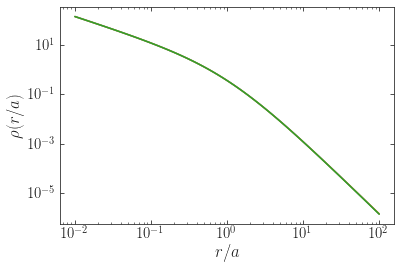

In [36]:
rs= numpy.geomspace(1e-2,1e2,101)*np2.a
loglog(rs/np2.a,np2.dens(rs,0))
dfdens= [nodf.vmomentdensity(r,0,0) for r in rs]
loglog(rs/np2.a,dfdens)
odfdens= [odf.vmomentdensity(r,0,0) for r in rs]
loglog(rs/np2.a,odfdens)
xlabel(r'$r/a$')
ylabel(r'$\rho(r/a)$');

All three agree well! But let's look more carefully at the relative density

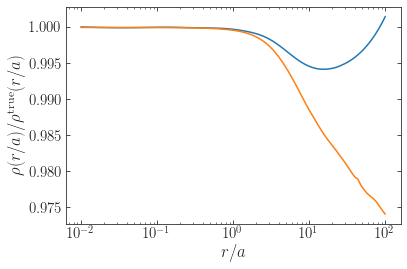

In [37]:
semilogx(rs/np2.a,numpy.array(dfdens)/np2.dens(rs,0))
semilogx(rs/np2.a,numpy.array(odfdens)/np2.dens(rs,0))
xlabel(r'$r/a$')
ylabel(r'$\rho(r/a)/\rho^{\mathrm{true}}(r/a)$');

Thus, the approximate form agrees well with the target density, even a little better than the direct numerical integration of the Osipkov-Merritt DF. Relative density differences are within one percent for the approximate form. We can also look at the radial velocity dispersion and compare it to the expected trend from solving the Jeans equation:

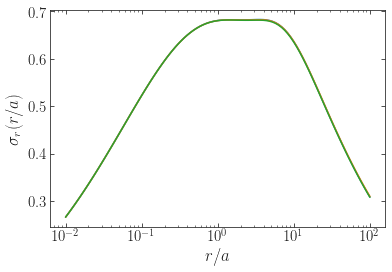

In [38]:
semilogx(rs/np2.a,numpy.array([jeans.sigmar(np2,r,beta=lambda r: 1./(1+ra**2./r**2.)) for r in rs]))
semilogx(rs/np2.a,[nodf.sigmar(r) for r in rs])
semilogx(rs/np2.a,[odf.sigmar(r) for r in rs])
xlabel(r'$r/a$')
ylabel(r'$\sigma_r(r/a)$');

Let's again also look at the relative performance:

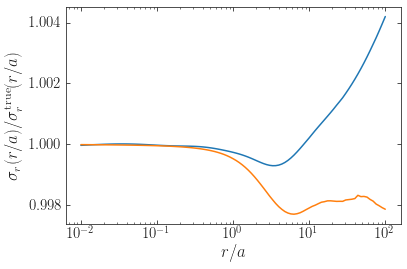

In [39]:
semilogx(rs/np2.a,[nodf.sigmar(r)/jeans.sigmar(np2,r,beta=lambda r: 1./(1+ra**2./r**2.)) for r in rs])
semilogx(rs/np2.a,[odf.sigmar(r)/jeans.sigmar(np2,r,beta=lambda r: 1./(1+ra**2./r**2.)) for r in rs])
xlabel(r'$r/a$')
ylabel(r'$\sigma_r(r/a)/\sigma^{\mathrm{true}}_r(r/a)$');

That again looks quite good! We can also look at $\beta$, but it is important to realize that $\beta$ always has the right form as long as the DF is only a function of $Q$ (that is, even if the density profile is completely wrong!). Thus, the $\beta$ profile is almost exact:

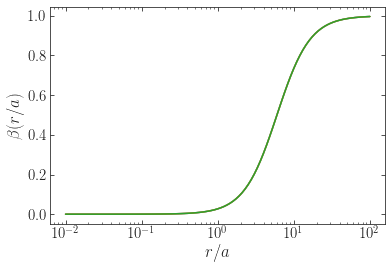

In [40]:
semilogx(rs/np2.a,1./(1+ra**2./rs**2.))
semilogx(rs/np2.a,[nodf.beta(r) for r in rs])
semilogx(rs/np2.a,[odf.beta(r) for r in rs])
xlabel(r'$r/a$')
ylabel(r'$\beta(r/a)$');

as seen especially well in the relative $\beta$:

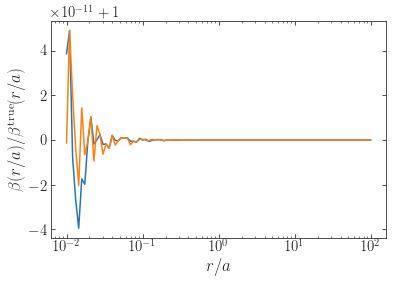

In [41]:
semilogx(rs/np2.a,[nodf.beta(r)/(1./(1+ra**2./r**2.)) for r in rs])
semilogx(rs/np2.a,[odf.beta(r)/(1./(1+ra**2./r**2.)) for r in rs])
xlabel(r'$r/a$')
ylabel(r'$\beta(r/a)/\beta^{\mathrm{true}}(r/a)$');

That all looks good!

## DF with constant anisotropy

DFs with constant anisotropy $\beta$ are given by the form

\begin{equation}
    f(\mathcal{E},L) = L^{-2\beta}\,f_1(\mathcal{E}\,.
\end{equation}

For half-integer values of $\beta$, the function $f_1(\mathcal{E})$ for a given density profile $\rho$ is given by

\begin{equation}
    f(\mathcal{E},L) = {1 \over 2\pi^2\,(-2\beta)!!}\,L^{-2\beta}\,{\mathrm{d}^{3/2-\beta} \over \mathrm{d} \Psi^{3/2-\beta}}\Big(\rho(\Psi)\,[r(\Psi)]^{2\beta}\Big)\,,\quad 1/2-\beta \in \mathbb{N}\,.
\end{equation}

For other values of $\beta$, we need to perform the following integral

\begin{align}
    f(\mathcal{E},L) = &{2^\beta\,L^{-2\beta} \over (2\pi)^{3/2}\,\Gamma(1-\alpha)\,\Gamma(1-\beta)}\nonumber\\&\quad \times\,\left[\int_0^\mathcal{E}\mathrm{d}\Psi\,{1\over (\Psi-\mathcal{E})^\alpha}\,{\mathrm{d}^{m+1} \over \mathrm{d} \Psi^{m+1}}\Big(\rho(\Psi)\,[r(\Psi)]^{2\beta}\Big)\right.\label{eq-anidf-constbeta-generalsol} \\&\qquad \ \ \left.+{1\over \mathcal{E}^\alpha}\,{\mathrm{d}^{m} \over \mathrm{d} \Psi^{m}}\Big(\rho(\Psi)\,[r(\Psi)]^{2\beta}\Big)\Big|_{\Psi=0}\right]\,.\nonumber
\end{align}

This is implemented in `galpy`'s `constantbetadf` and we can compute the DF for a few values of $\beta$:

In [64]:
twobetas= [1.5,1,0.5,0,-0.5,-1,-1.5,-2,-2.5,-3,-3.5,-4,-4.5,-5,-5.5]
cdfs= []
for twobeta in twobetas:
    cdfs.append(constantbetadf(pot=np,twobeta=twobeta))

/Users/bovy/miniconda3/envs/py37/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')

/Users/bovy/tmp/galpy-spheredf/galpy/df/constantbetadf.py:295: RuntimeWarning: invalid value encountered in power
  out[:]= dmp1nudrmp1(r)/(_evaluatePotentials(pot,r,0)-E)**alpha

/Users/bovy/tmp/galpy-spheredf/galpy/df/constantbetadf.py:295: RuntimeWarning: invalid value encountered in sqrt
  out[:]= dmp1nudrmp1(r)/(_evaluatePotentials(pot,r,0)-E)**alpha



and we compute $f(\mathcal{E})$ (multiplying the raw output by $4\pi$ to get the DF in the scaled units)

In [65]:
savefile= 'nfw_constantbeta_coarse.dat'
mEs= numpy.linspace(-np(0,0)*0.995,0,201)
if os.path.exists(savefile):
    f1mEs= numpy.loadtxt(savefile)
else:
    with mp.Pool(mp.cpu_count()) as p:
        def _calc_one(x):
            # Separate process, so need to import everything necessary
            import numpy
            from galpy.potential import NFWPotential
            from galpy.df import constantbetadf
            np= NFWPotential(amp=1.,a=1.)  
            mEs= numpy.linspace(-np(0,0)*0.995,0,201)
            twobetas= [1.5,1,0.5,0,-0.5,-1,-1.5,-2,-2.5,-3,-3.5,-4,-4.5,-5,-5.5]
            twobeta= twobetas[x]
            cdf= constantbetadf(pot=np,twobeta=twobeta)
            return 4.*numpy.pi*cdf.fE(-mEs)
        f1mEs= numpy.array(p.map(_calc_one,range(len(twobetas))))
        numpy.savetxt(savefile,f1mEs)

and we can plot them

In [66]:
from matplotlib import cm
cmap= cm.plasma
def color_from_colormap(val,cmap,cmin,cmax):
    return cmap((val-cmin)/(cmax-cmin))
def add_discrete_colorbar(vmin,vmax,clabel,ticks,fmt=r'$%.1f$'):
    fig= pyplot.gcf()
    cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
    dtick= (ticks[1]-ticks[0])
    sm = pyplot.cm.ScalarMappable(cmap=tcmap,
                                  norm=pyplot.Normalize(vmin=vmin-0.5*dtick,vmax=vmax+0.5*dtick))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=fmt,
                       ticks=ticks)
    cbar.set_label(clabel)
    return None

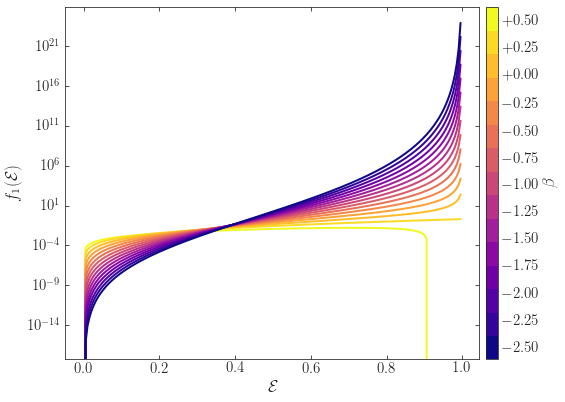

In [67]:
figsize(7,6)
fig= figure()
fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
for ii,twobeta in enumerate(twobetas):
    semilogy(mEs,f1mEs[ii],lw=2.,color=color_from_colormap(twobeta/2.,cmap,twobetas[-1]/2.,twobetas[0]/2.))
xlabel(r'$\mathcal{E}$')
ylabel(r'$f_1(\mathcal{E})$')
add_discrete_colorbar(twobetas[-1]/2.,twobetas[0]/2.,
                      r'$\beta$',[t/2. for t in twobetas],fmt=r'$%+.2f$');

finer grid:

In [68]:
savefile= 'nfw_constantbeta_fine.dat'
#twobetas= 2.*numpy.arange(0.95,-4.05,-0.05)
twobetas= 2.*numpy.arange(0.95,-3.5,-0.05)
# To re-run leaving out already done ones
keep= numpy.arange(len(twobetas),dtype='int')
if False:
    keepthese= []
    for ii,twobeta in enumerate(twobetas):
        if not os.path.exists('nfw_constantbeta_fine_{:+.2f}.dat'.format(twobeta)):
            keepthese.append(keep[ii])
    print(keepthese,twobetas[keepthese])
else: # final gathering
    keepthese= keep
mEs= numpy.linspace(-np(0,0)*0.995,0,201)
if os.path.exists(savefile):
    f1mEs= numpy.loadtxt(savefile)
else:
    with mp.Pool(mp.cpu_count()) as p:
        def _calc_one(x):
            # Separate process, so need to import everything necessary
            import numpy
            from galpy.potential import NFWPotential
            from galpy.df import constantbetadf
            import os, os.path
            np= NFWPotential(amp=1.,a=1.)  
            mEs= numpy.linspace(-np(0,0)*0.995,0,201)
            twobetas= 2.*numpy.arange(0.95,-3.5,-0.05)
            twobeta= twobetas[x]
            this_savefile= 'nfw_constantbeta_fine_{:+.2f}.dat'.format(twobeta)
            if os.path.exists(this_savefile):
                out= numpy.loadtxt(this_savefile)
                return out
            else:
                cdf= constantbetadf(pot=np,twobeta=twobeta)
                out= 4.*numpy.pi*cdf.fE(-mEs)
                numpy.savetxt(this_savefile,out)
                return out
        f1mEs= numpy.array(p.map(_calc_one,keepthese))
        numpy.savetxt(savefile,f1mEs)

In [69]:
from matplotlib import cm
cmap= cm.plasma
def add_colorbar(vmin,vmax,clabel,fmt=r'$%.1f$'):
    fig= pyplot.gcf()
    cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    sm= pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=fmt)
    cbar.set_label(clabel)
    return None

In [72]:
figsize(7,6)
fig= figure()
fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
for ii,twobeta in enumerate(twobetas):
    semilogy(mEs,f1mEs[ii],lw=2.,color=color_from_colormap(twobeta/2.,cmap,twobetas[-1]/2.,twobetas[0]/2.))
xlabel(r'$\mathcal{E}/(4\pi\,G\,\rho_0\,a^2)$')
ylabel(r'$f_1(\mathcal{E})\times(4\pi G)^{3/2}\,a^3\,\rho_0^{1/2}$')
add_colorbar(twobetas[-1]/2.,1.,r'$\beta$',fmt=r'$%+.2f$');
if _SAVE_FIGURES:
    galpy_plot.end_print('../plots/constantbeta_nfw.pdf',bbox_inches='tight')